In [1]:
import numpy as np
import pandas as pd

import lightgbm as lgb

from sklearn.feature_selection import VarianceThreshold

from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import time
import gc

In [9]:
train_datapath_2016 = "./zillow data/merged_2016 v4.csv"
train_datapath_2017 = "./zillow data/merged_2017 v4.csv"

test_datapath_2016 = "./zillow data/properties_2016 v4.csv"
test_datapath_2017 = "./zillow data/properties_2017 v4.csv"

In [30]:
# modify 'transactiondate' of df to keep only the month
def parse_transactiondate(df):
    # modify transactiondate col to keep only the month
    new_transactiondate = []
    for data in df['transactiondate']:
        temp = data.split("-")
        new_transactiondate.append(int(temp[1])) # keep only month

    new_transactiondate = np.array(new_transactiondate)
    new_transactiondate = new_transactiondate.reshape(new_transactiondate.shape[0], 1)

    df['transactiondate'] = new_transactiondate

# return label index, feature index list
# assumes that df label_is_first
def split_on_label(df):
    return df.columns[0], df.columns[1:]

def gen_testdata(df, new_transactiondate):
    df_copy = df.copy()
    # df_copy['transactiondate'] = new_transactiondate
    df_copy.insert(0, 'transactiondate', new_transactiondate)
    return df_copy

def get_low_var_feature(support_list):
    low_var_feature_index = []
    support_feature_index = []
    for i in range(len(support_list)):
        if support_list[i]:
            support_feature_index.append(i)
        else:
            low_var_feature_index.append(i)
    return low_var_feature_index, support_feature_index


def handle_low_var(sel, train_data, feature_list):
    temp_sel = sel.fit(train_data)
    low_var_list, support_list = get_low_var_feature(sel.get_support())

    return low_var_list


# Removing Features with more than 98% missing data
def removing_missing(X_train, missing_threshold = 0.95):
    exclude_missing = []
    num_rows = X_train.shape[0]
    for col in X_train.columns:
        num_missing = X_train[col].isna().sum()
        if num_missing == 0:
            continue
        missing_fraction = num_missing/float(num_rows)
        if missing_fraction > missing_threshold:
            exclude_missing.append(col)
            
    return exclude_missing

# removing features with unique value
def removing_unique(X_train):
    exclude_unique = []
    for col in X_train.columns:
        num_unique = len(X_train[col].unique())
        if X_train[col].isna().sum()!=0 and num_unique == 1:
            exclude_unique.append(col)
            
    return exclude_unique

def print_list(li,list_name = ''):
    print('%s (%d) :' %(list_name,len(li)))
    for i in li:
        print(i)
        
def get_train_features(X_train,el1 = [], el2 = [], el3 = [],el4 = []):
    train_feature = []
    for col in X_train:
        if col not in el1 and col not in el2 and col not in el3 and col not in el4:
            train_feature.append(col)
    return train_feature

# geting categorical features
def get_cat_feature(X_train, cat_threshold):
    cat_feature_inds = []
    cat_feature = []
    for i,col in enumerate(X_train):
        num_uniques = len(X_train[col].unique())
        if num_uniques < cat_threshold and not 'sqft' in col and not 'cnt' in col \
        and not 'nbr' in col and not 'number' in col:
            cat_feature_inds.append(i)
            cat_feature.append(col)
    return cat_feature_inds,cat_feature

In [11]:
# read training data
train_data16 = pd.read_csv(train_datapath_2016, index_col=0)
train_data17 = pd.read_csv(train_datapath_2017, index_col=0)

# drop parcelid (index of properties features)
train_data16 = train_data16.drop('parcelid', axis=1)
train_data17 = train_data17.drop('parcelid', axis=1)

label16, feature16 = split_on_label(train_data16)
label17, feature17 = split_on_label(train_data17)

print("[2016] num of features:", len(feature16))
print("[2016] num of instances:", train_data16.shape[0])

print("[2017] num of features:", len(feature17))
print("[2017] num of instances:", train_data17.shape[0])

# modify 'transactiondate' to keep only the month
parse_transactiondate(train_data16)
parse_transactiondate(train_data17)

# training data and label for model 2016
X_train16 = train_data16[feature16]
y_train16 = train_data16[label16]

# training data and label for model 2017
X_train17 = train_data17[feature17]
y_train17 = train_data17[label17]

del train_data16, train_data17
gc.collect()

[2016] num of features: 58
[2016] num of instances: 90275
[2017] num of features: 58
[2017] num of instances: 77613


14

In [26]:
# Removing Freatures with too many missing data
exclude_missing16 = removing_missing(X_train16)
exclude_missing17 = removing_missing(X_train17)

# Removing Features with unique values
exclude_unique16 = removing_unique(X_train16)
exclude_unique17 = removing_unique(X_train17)

# Removing Features with low variance
# it should remove features with many missing values that were filled by imputation
#sel = VarianceThreshold(threshold=(.8 * (1 - .8)))

#exclude_low_var16 = handle_low_var(sel, X_train16, feature16)
#exclude_low_var17 = handle_low_var(sel, X_train17, feature17)

In [27]:
print_list(exclude_missing16,'exclude_missing16')
#print_list(exclude_low_var16,'exclude_low_var16')
print_list(exclude_unique16,'exclude_unique17')

print_list(exclude_missing17,'exclude_missing17')
#print_list(exclude_low_var17,'exclude_low_var16')
print_list(exclude_unique17,'exclude_unique17')

exclude_missing16 (18) :
architecturalstyletypeid
basementsqft
buildingclasstypeid
decktypeid
finishedsquarefeet13
finishedsquarefeet15
finishedsquarefeet6
hashottuborspa
poolsizesum
pooltypeid10
pooltypeid2
storytypeid
typeconstructiontypeid
yardbuildingsqft17
yardbuildingsqft26
fireplaceflag
taxdelinquencyflag
taxdelinquencyyear
exclude_unique17 (0) :
exclude_missing17 (18) :
architecturalstyletypeid
basementsqft
buildingclasstypeid
decktypeid
finishedsquarefeet13
finishedsquarefeet15
finishedsquarefeet6
hashottuborspa
poolsizesum
pooltypeid10
pooltypeid2
storytypeid
typeconstructiontypeid
yardbuildingsqft17
yardbuildingsqft26
fireplaceflag
taxdelinquencyflag
taxdelinquencyyear
exclude_unique17 (0) :


In [28]:
train_feature16 = get_train_features(X_train16, el1 = exclude_missing16, 
                                                #el2 = exclude_low_var16,
                                                el3 = exclude_unique16)
train_feature17 = get_train_features(X_train17, el1 = exclude_missing17, 
                                                #el2 = exclude_low_var17,
                                                el3 = exclude_unique17)

new_X_train16 = X_train16[train_feature16]
new_X_train17 = X_train17[train_feature17]

print("\n[2016] num of features:", new_X_train16.shape[1])
print("[2017] num of features:", new_X_train17.shape[1])
print_list(train_feature16,"train_feature16")
print_list(train_feature17,"train_feature17")


[2016] num of features: 40
[2017] num of features: 40
train_feature16 (40) :
transactiondate
airconditioningtypeid
bathroomcnt
bedroomcnt
buildingqualitytypeid
calculatedbathnbr
finishedfloor1squarefeet
calculatedfinishedsquarefeet
finishedsquarefeet12
finishedsquarefeet50
fips
fireplacecnt
fullbathcnt
garagecarcnt
garagetotalsqft
heatingorsystemtypeid
latitude
longitude
lotsizesquarefeet
poolcnt
pooltypeid7
propertycountylandusecode
propertylandusetypeid
propertyzoningdesc
rawcensustractandblock
regionidcity
regionidcounty
regionidneighborhood
regionidzip
roomcnt
threequarterbathnbr
unitcnt
yearbuilt
numberofstories
structuretaxvaluedollarcnt
taxvaluedollarcnt
assessmentyear
landtaxvaluedollarcnt
taxamount
censustractandblock
train_feature17 (40) :
transactiondate
airconditioningtypeid
bathroomcnt
bedroomcnt
buildingqualitytypeid
calculatedbathnbr
finishedfloor1squarefeet
calculatedfinishedsquarefeet
finishedsquarefeet12
finishedsquarefeet50
fips
fireplacecnt
fullbathcnt
garagecarcnt

In [31]:
cat_feature_inds16, cat_feature16 = get_cat_feature(new_X_train16, cat_threshold = 1000)
cat_feature_inds17, cat_feature17 = get_cat_feature(new_X_train17, cat_threshold = 1000)
print_list(cat_feature16,'cat_feature16')
print_list(cat_feature17,'cat_feature17')

cat_feature16 (14) :
transactiondate
airconditioningtypeid
buildingqualitytypeid
fips
heatingorsystemtypeid
pooltypeid7
propertycountylandusecode
propertylandusetypeid
regionidcity
regionidcounty
regionidneighborhood
regionidzip
yearbuilt
assessmentyear
cat_feature17 (14) :
transactiondate
airconditioningtypeid
buildingqualitytypeid
fips
heatingorsystemtypeid
pooltypeid7
propertycountylandusecode
propertylandusetypeid
regionidcity
regionidcounty
regionidneighborhood
regionidzip
yearbuilt
assessmentyear


### Feauture Selection

In [32]:
def handle_lightgbm_GridCV(X, y, param_dict):
    
    # cross-validate on alpha (regularization strenght) from alphalist
    
    gbm = lgb.LGBMRegressor(n_jobs = -1, random_state = 42,silent = False)
       
    # cross-validate on random search CV
    grid_search = GridSearchCV(gbm,param_grid=param_dict,
                               cv=10, scoring='neg_mean_absolute_error')
    
    start = time.time()
    grid_search.fit(X, y)
    print("GridSearchCV took %.2f seconds"
          " parameter settings." % (time.time() - start))

    return grid_search

In [45]:
params_dict = {
    "learning_rate":[0.012],
    'num_leaves':[127],
    'max_depth':[-1],
    'reg_alpha':[0.01],
    'reg_lambda':[100],
    'min_split_gain':[0],
    'min_child_samples':[10],
    'colsample_bytree':[0.8],
    
    'min_child_weight':[0.001],
    'subsample':[0.8],
    'subsample_for_bin':[50000],
    'subsample_freq':[1], 
    'n_eatimators':[512],
    'ramdon_state':[21]
}
grid_result = handle_lightgbm_GridCV(new_X_train16, y_train16, params_dict)

GridSearchCV took 269.81 seconds parameter settings.


In [47]:
grid_result.grid_scores_

/Users/apple/venv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.06781, std: 0.00331, params: {'colsample_bytree': 0.8, 'learning_rate': 0.012, 'max_depth': -1, 'min_child_samples': 10, 'min_child_weight': 0.001, 'min_split_gain': 0, 'n_eatimators': 512, 'num_leaves': 127, 'ramdon_state': 21, 'reg_alpha': 0.01, 'reg_lambda': 100, 'subsample': 0.8, 'subsample_for_bin': 50000, 'subsample_freq': 1},
 mean: -0.06781, std: 0.00331, params: {'colsample_bytree': 0.8, 'learning_rate': 0.012, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0, 'n_eatimators': 512, 'num_leaves': 127, 'ramdon_state': 21, 'reg_alpha': 0.01, 'reg_lambda': 100, 'subsample': 0.8, 'subsample_for_bin': 50000, 'subsample_freq': 1},
 mean: -0.06782, std: 0.00331, params: {'colsample_bytree': 0.8, 'learning_rate': 0.012, 'max_depth': -1, 'min_child_samples': 30, 'min_child_weight': 0.001, 'min_split_gain': 0, 'n_eatimators': 512, 'num_leaves': 127, 'ramdon_state': 21, 'reg_alpha': 0.01, 'reg_lambda': 100, 'subsample': 0.8, 'subsample_for_

### Learning Curve

In [184]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve

In [185]:
def plot_learning_curve(estimator, X, y, ylim=None, cv=None, train_sizes=np.linspace(.05, 1., 20), verbose=0, plot=True):
    
    train_sizes, train_scores, test_scores = learning_curve(
            estimator, X, y, cv=cv, train_sizes=train_sizes, scoring = 'neg_mean_absolute_error',verbose=verbose)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    if plot:
        plt.figure()
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel(u"number of samples")
        plt.ylabel(u"score")
        plt.gca().invert_yaxis()
        plt.grid()
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                         alpha=0.1, color="b")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                         alpha=0.1, color="r")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label=u"training set score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label=u"validation set score")

        plt.legend(loc="best")

        plt.draw()
        plt.show()
        plt.gca().invert_yaxis()

    midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
    diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
    return midpoint, diff

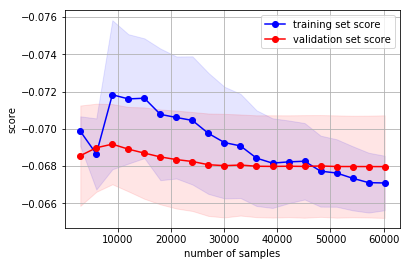

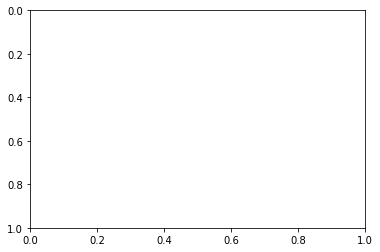

In [186]:
params = {"learning_rate":0.011,
          'n_estimators':100,
          'num_leaves':145,
          'max_depth':-1,
          'reg_alpha':0.01,
          'reg_lambda':100,
          'colsample_bytree':0.8,
          'min_split_gain':0,
          'min_child_samples':300,
          'min_child_weight':0.001,
          'subsample':1.0,
          'subsample_for_bin':50000,
          'subsample_freq':1, 
          }
bst = lgb.LGBMRegressor(n_jobs = -1, random_state = 42,silent = False,
                            learning_rate = params['learning_rate'],
                            n_estimators = params['n_estimators'],
                            num_leaves = params['num_leaves'],
                            reg_alpha = params['reg_alpha'],
                            reg_lambda = params['reg_lambda'],
                            min_split_gain = params['min_split_gain'],
                            min_child_samples = params['min_child_samples'],
                            subsample = params['subsample'],
                            subsample_for_bin = params['subsample_for_bin'],
                            colsample_bytree = params['colsample_bytree'],
                            subsample_freq = params['subsample_freq'],
                            max_depth = params['max_depth'],
                            min_child_weight = params['min_child_weight']
                        
                           )
_,_ = plot_learning_curve(bst, X_train16, y_train16)

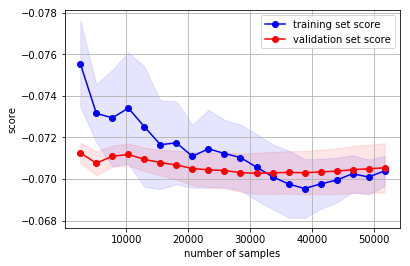

(-0.0707023234150505, 0.0020501947711049767)

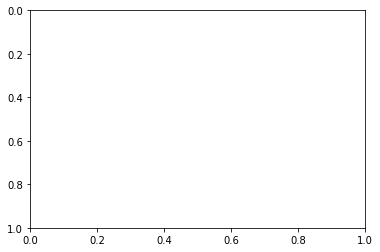

In [88]:
params = {"learning_rate":0.011,
          'n_estimators':100,
          'num_leaves':145,
          'max_depth':-1,
          'reg_alpha':0.01,
          'reg_lambda':100,
          'colsample_bytree':0.8,
          'min_split_gain':0,
          'min_child_samples':300,
          'min_child_weight':0.001,
          'subsample':1.0,
          'subsample_for_bin':50000,
          'subsample_freq':1,
         }
bst = lgb.LGBMRegressor(n_jobs = -1, random_state = 42,silent = False,
                            learning_rate = params['learning_rate'],
                            n_estimators = params['n_estimators'],
                            num_leaves = params['num_leaves'],
                            reg_alpha = params['reg_alpha'],
                            reg_lambda = params['reg_lambda'],
                            min_split_gain = params['min_split_gain'],
                            min_child_samples = params['min_child_samples'],
                            subsample = params['subsample'],
                            subsample_for_bin = params['subsample_for_bin'],
                            colsample_bytree = params['colsample_bytree'],
                            subsample_freq = params['subsample_freq'],
                            max_depth = params['max_depth'],
                            min_child_weight = params['min_child_weight']
                           )
_,_ = plot_learning_curve(bst, X_train17, y_train17)

In [187]:
# read in test
test_data2016 = pd.read_csv(test_datapath_2016, index_col=0)
test_data2017 = pd.read_csv(test_datapath_2017, index_col=0)

print("[2016] num of instances: ", test_data2016.shape[0])
print("[2017] num of instances: ", test_data2017.shape[0])

# save parcelid for merge 
test_parcelid16 = test_data2016['parcelid']
test_parcelid17 = test_data2017['parcelid']

# drop parcelid col
test_data2016 = test_data2016.drop('parcelid', axis=1)
test_data2017 = test_data2017.drop('parcelid', axis=1)

# generate transaction date
test10_16 = np.repeat(10, test_data2016.shape[0])
test11_16 = np.repeat(11, test_data2016.shape[0])
test12_16 = np.repeat(12, test_data2016.shape[0])

test10_17 = np.repeat(10, test_data2017.shape[0])
test11_17 = np.repeat(11, test_data2017.shape[0])
test12_17 = np.repeat(12, test_data2017.shape[0])

# get new test data with transaction date
X_test10_16 = gen_testdata(test_data2016, test10_16)
X_test11_16 = gen_testdata(test_data2016, test11_16)
X_test12_16 = gen_testdata(test_data2016, test12_16)

X_test10_17 = gen_testdata(test_data2017, test10_17)
X_test11_17 = gen_testdata(test_data2017, test11_17)
X_test12_17 = gen_testdata(test_data2017, test12_17)

/Users/apple/venv/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


[2016] num of instances:  2985217
[2017] num of instances:  2985217


In [188]:
def train_and_test(X_train,y_train,X_test, params):
    
    bst = lgb.LGBMRegressor(n_jobs = -1, random_state = 42,silent = False,
                            learning_rate = params['learning_rate'],
                            n_estimators = params['n_estimators'],
                            num_leaves = params['num_leaves'],
                            reg_alpha = params['reg_alpha'],
                            reg_lambda = params['reg_lambda'],
                            min_split_gain = params['min_split_gain'],
                            min_child_samples = params['min_child_samples'],
                            subsample = params['subsample'],
                            subsample_for_bin = params['subsample_for_bin'],
                            colsample_bytree = params['colsample_bytree'],
                            subsample_freq = params['subsample_freq'],
                            max_depth = params['max_depth'],
                            min_child_weight = params['min_child_weight']
                           )
    bst.fit(X_train, y_train)
    y_pred = bst.predict(X_test)
    
    return y_pred

In [190]:
best_params_16 = {"learning_rate":0.011,
                  'n_estimators':100,
                  'num_leaves':145,
                  'max_depth':-1,
                  'reg_alpha':0.01,
                  'reg_lambda':100,
                  'colsample_bytree':0.8,
                  'min_split_gain':0,
                  'min_child_samples':300,
                  'min_child_weight':0.001,
                  'subsample':0.8,
                  'subsample_for_bin':50000,
                  'subsample_freq':1,
                 }
y_pred10_16 = train_and_test(X_train16, y_train16, X_test10_16.values,best_params_16)
y_pred11_16 = train_and_test(X_train16, y_train16, X_test11_16.values,best_params_16)
y_pred12_16 = train_and_test(X_train16, y_train16, X_test12_16.values,best_params_16)

best_params_17 = {"learning_rate":0.011,
                  'n_estimators':100,
                  'num_leaves':80,
                  'max_depth':-1,
                  'reg_alpha':0.01,
                  'reg_lambda':500,
                  'colsample_bytree':0.6,
                  'min_split_gain':0,
                  'min_child_samples':300,
                  'min_child_weight':0.001,
                  'subsample':0.8,
                  'subsample_for_bin':50000,
                  'subsample_freq':1,
                  }
y_pred10_17 = train_and_test(X_train17, y_train17, X_test10_17.values,best_params_17)
y_pred11_17 = train_and_test(X_train17, y_train17, X_test11_17.values,best_params_17)
y_pred12_17 = train_and_test(X_train17, y_train17, X_test12_17.values,best_params_17)

In [191]:
# merged on Parcelid for predicted result on test data

test_dict_16 = {'Parcelid': test_parcelid16, '201610': y_pred10_16, '201611': y_pred11_16, '201612': y_pred12_16}
test_dict_17 = {'Parcelid': test_parcelid17, '201710': y_pred10_17, '201711': y_pred11_17, '201712': y_pred12_17}

df_test_16 = pd.DataFrame(data=test_dict_16)
df_test_17 = pd.DataFrame(data=test_dict_17)

df_merged = df_test_16.merge(df_test_17, left_on='Parcelid', right_on='Parcelid', how='outer')
print(df_merged)

# handle submission file
submitfile = "./zillow data/sample_submission.csv"

submit_df = pd.read_csv(submitfile)
print(submit_df.shape[0], submit_df.shape[1])

assert(submit_df.shape[0] == df_merged.shape[0]), "Error: invalid row size for submit!"
df_merged.to_csv("./zillow data/draft_submission6.csv", index=False)

          Parcelid    201610    201611    201612    201710    201711    201712
0         10754147  0.036061  0.036061  0.036061  0.036070  0.036070  0.036070
1         10759547  0.029670  0.029670  0.029670  0.034878  0.034878  0.034878
2         10843547  0.041892  0.041892  0.041892  0.023015  0.023015  0.023015
3         10859147  0.028555  0.028555  0.028555  0.034286  0.034286  0.034286
4         10879947  0.007023  0.007023  0.007023  0.009165  0.009165  0.009165
5         10898347  0.009329  0.009329  0.009329  0.017094  0.017094  0.017094
6         10933547  0.006379  0.006432  0.006463  0.009195  0.009195  0.009195
7         10940747  0.016154  0.016154  0.016154  0.019002  0.019002  0.019002
8         10954547  0.034844  0.034844  0.034844  0.036188  0.036188  0.036188
9         10976347  0.012069  0.012069  0.012069  0.020487  0.020487  0.020487
10        11073947  0.002881  0.002881  0.003000  0.013769  0.013769  0.013769
11        11114347  0.036789  0.036789  0.036789  0.

In [131]:
df_merged.to_csv("./zillow data/draft_submission4.csv", index=False)